# ResOpsES - Attributes from meteorology
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 25-11-2024<br>

**Introduction:**<br>
This notebook creates the static attributes for the catchmens of the reservoirs in the ResOpsES dataset.

**To do:**<br>

In [ ]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from tqdm.notebook import tqdm
from datetime import datetime
from shapely.geometry import Point
import yaml

from reservoirs_lshm.utils.plots import plot_attributes
from reservoirs_lshm.utils import DatasetConfig
from reservoirs_lshm.utils.utils import duration_precip_indices

import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics

## Configuration

In [2]:
cfg = DatasetConfig('config_dataset.yml')

PATH_METEO = cfg.PATH_RESOPS / 'ancillary' / 'catchstats' / 'meteo'

PATH_PLOTS = cfg.PATH_ATTRS / 'plots'
PATH_PLOTS.mkdir(parents=False, exist_ok=True)

## Data

### Reservoirs

In [49]:
# load TXT used as input for `cutmaps`
reservoirs = pd.read_csv(cfg.PATH_RESOPS / 'ancillary' / 'cutmaps' / 'reservoirs.txt', sep='\t', header=None)
reservoirs.columns = ['lon', 'lat', 'SNCZI']
reservoirs.set_index('SNCZI', drop=True, inplace=True)

# convert index to GRAND_ID
map_snczi_grand = pd.read_csv(cfg.PATH_ATTRS / 'grand.csv', usecols=['GRAND_ID', 'SNCZI'])#, index_col='SNCZI').astype('Int64').squeeze()
map_snczi_grand = map_snczi_grand.astype(int)
map_snczi_grand = map_snczi_grand.set_index('SNCZI', drop=True).squeeze()
ids = reservoirs.index.intersection(map_snczi_grand.index)
reservoirs = reservoirs.loc[ids]
map_snczi_grand = map_snczi_grand[ids]
reservoirs.index = reservoirs.index.map(map_snczi_grand)
reservoirs.index.name = 'GRAND_ID'

### Meteorology

In [57]:
# load areal meteo time series
meteo = {}
variables = [item.stem for item in PATH_METEO.glob('*') if item.is_dir()]
for var in tqdm(variables):
    da = xr.open_mfdataset(f'{PATH_METEO}/{var}/*.nc')[f'{var}_mean'].compute()
    da.name = var
    da = da.rename({'id': 'ID'})
    da = da.sel(ID=map_snczi_grand.index)
    da = da.assign_coords(ID=('ID', map_snczi_grand))
    meteo[var] = da
meteo = xr.Dataset(meteo)

meteo = meteo.rename({'pr': 'precip', 'ta': 'temp', 'e0': 'pet'})

# compute precipitation as snowfall
meteo['snow'] = meteo['precip'].where(meteo['temp'] > 1, 0)

  0%|          | 0/3 [00:00<?, ?it/s]

## Attributes

In [59]:
# average of all meteo variables
attrs = meteo.mean('time').to_pandas()
attrs.columns = [f'{col}_mean' for col in attrs.columns]
attrs.index.name = 'GRAND_ID'

# indices
attrs['aridity'] = attrs.precip_mean / attrs.pet_mean
attrs['frac_snow'] = attrs.snow_mean / attrs.precip_mean
attrs['moisture_index'] = attrs.precip_mean - attrs.pet_mean
precip_monthly = meteo['precip'].resample({'time': '1M'}).sum().groupby('time.month').mean()
precip_annual = meteo['precip'].resample({'time': 'A'}).sum().mean('time')
attrs['seasonality'] = ((precip_monthly.max('month') - precip_monthly.min('month')) / precip_annual).to_pandas()

# high and dry precipitation indices
precip_extremes = {
    'high': 20, # mm
    'low': 1 # mm
}
for key, value in precip_extremes.items():
    if key == 'high':
        mask_precip = meteo['precip'] > value
    elif key == 'low':
        mask_precip = meteo['precip'] < value
    attrs[f'{key}_precip_freq'] = mask_precip.sum('time') / len(meteo.time)
    attrs[f'{key}_precip_dur'] = duration_precip_indices(mask_precip.to_pandas())

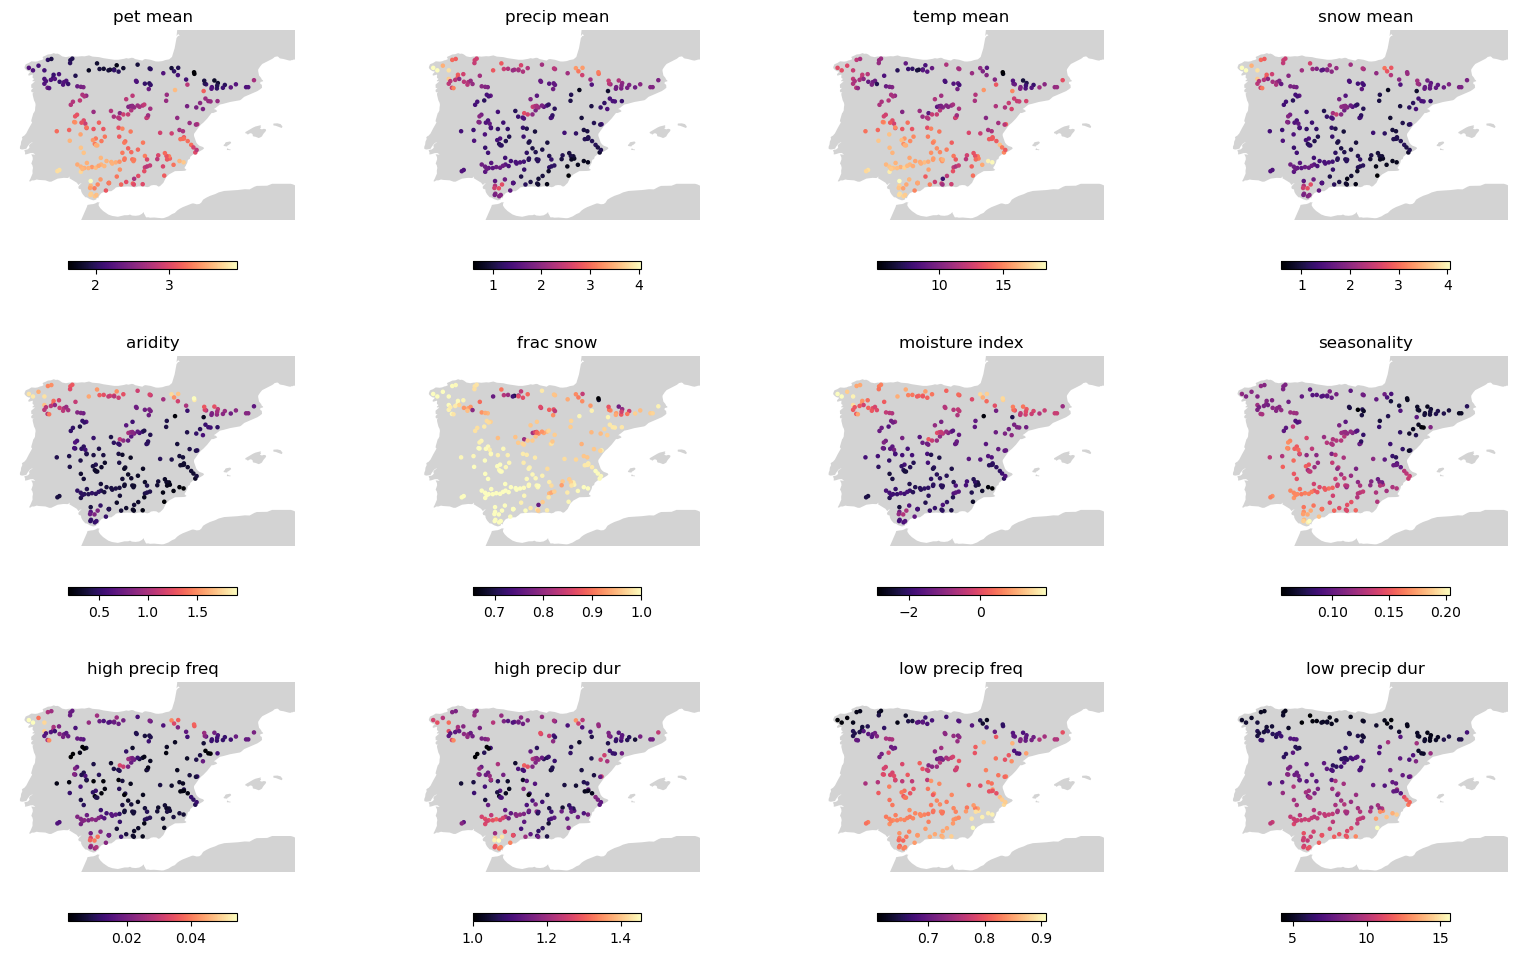

In [60]:
# plot attributes
r = 5
extent = [np.floor(reservoirs.lon.min() / r) * r, np.ceil(reservoirs.lon.max() / r) * r,
          np.floor(reservoirs.lat.min() / r) * r, np.ceil(reservoirs.lat.max() / r) * r]
plot_attributes(
    attrs,
    reservoirs.lon,
    reservoirs.lat,
    ncols=4,
    extent=extent,
    save=PATH_PLOTS / f'maps_climate.jpg'
)

In [62]:
# export
attrs.sort_index(axis=0).to_csv(cfg.PATH_ATTRS / 'climate_indices.csv', float_format='%.6f')